In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson, halfnorm
from scipy.ndimage import gaussian_filter
from copy import copy
import multiprocessing 
import pandas as pd
from matplotlib import rc, cm
from itertools import product
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

rc('text', usetex=True)
rc('font', family='serif')

## Helper Functions

In [3]:
## Round to nearest value on axis
def fn(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]
    
def generatePlaceFields1D(N,xaxis,L):
    # N: number of neurons
    # L: length of the linear track
    # dL: spatial discretization
    
    
    L = abs(xaxis[-1]-xaxis[0])
    dL = xaxis[1]-xaxis[0]
    f = np.zeros((N,xaxis.size))
    for i in range(N):
        # draw place field parameters randomly
        m = np.random.poisson(1) + 1   # number of place fields
        mu = np.random.uniform(xaxis.min(),xaxis.max(),m)  # place field centers
        sigma = np.random.uniform(dL,L/4,m) # place field width
        f0 = np.random.uniform(0,10,m) # maximal firing rate
        for j in range(m):
            f[i] = f[i] + f0[j] * np.exp(-(xaxis-mu[j])**2/sigma[j]**2)
    
    return f

def h(x,f,xaxis,dL):
# evaluates the place fields on a grid
# returns spiking frequencies at respective locations from x
    bins = xaxis-dL/2
    ind = np.digitize(x,bins) - 1
    hx = f[:,ind]
    
    return hx
    
    
def poisson_mean(spikes, i, x_k, x, time_bucket_length):
    if len(np.where(x==x_k)[0]) > 0:
        return spikes[np.where(x==x_k),i].sum()/(len(np.where(x==x_k)[0]) * time_bucket_length)
    return 0

def calculate_poisson(spikes, x, xaxis, time_bucket_length):
    poisson = {}
    num_neurons = spikes.shape[1]
    for x_k in xaxis:
        for i in range(num_neurons):
            pm = poisson_mean(spikes, i, x_k, x, time_bucket_length)
            poisson[i, x_k] = pm
    return poisson

def estimate_place_fields(spikes, X, xaxis, dt, sigma=40):
    poisson_dict = calculate_poisson(spikes, X, xaxis, dt)
    poisson_series = pd.Series(poisson_dict).reset_index()
    poisson_series.columns = ['neuron', 'location', 'poisson_mean']
    poisson_series = poisson_series.sort_values(['neuron', 'location']).reset_index(drop=True)
    estimated_place_fields = np.array(poisson_series.pivot(index='neuron',columns='location'))
    smoothed_place_fields = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=sigma), 1, estimated_place_fields)
    return estimated_place_fields, smoothed_place_fields

def resample(x,w,N):
    if x.shape[0] == 2:
        ix = np.random.choice(np.arange(x.shape[1]), p=w, size=N)
        x_r = x[:,ix]
    else:
        x_r = np.random.choice(x, p=w, size=N)
    w_r = np.ones(N) * (1.0/N)
    return x_r, w_r

## Integrated Random Walk PF

Integrated random walk generative model with boundary conditions. 
$$\frac{dx}{dt} =  v$$
$$dv = -\frac{dt}\tau v + q dW_t$$
$$dW_t \sim \mathcal{N} (0, dt)$$
$$p(v_t|v_{t-1}) = \mathcal{N} ( v_t; v_{t-1} - \frac{dt}{\tau}v_{t-1}, q^2 \times dt )$$
$dt$ somewhere around $0.1-0.001$, test and check.

### Generate Artificial Data

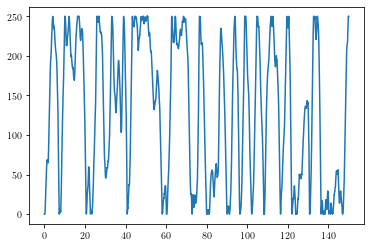

In [53]:
dt = 0.01
T = 150
t = np.arange(0,T,dt)
M = 10 # number of neurons
L = 250 # total length
dL = 0.1
P = 1000
Peff_min = 0.5
xaxis = np.arange(0,L,dL) + dL/2 # center of bins
find_nearest = np.vectorize(lambda x: fn(xaxis, x))

params = {
    "tau": 10,
    "q": 100,
    "dt": dt,
    "xaxis": xaxis, # axis for placefields
    "dL": dL,
    "T": T,
    "P": P,
    "Peff_min": Peff_min,
    "L": L
}

def generate_random_walk_trajectory(params):
    X = np.zeros((int(T/dt),2)) # x and v components
    X[0,0] = 0
    X[0,1] = 0 
    for i in np.arange(1,int(T/dt)):
        x = np.copy(X[i-1,0])
        v = np.copy(X[i-1,1])
        # integrate one timestep using Euler scheme
        X[i,0] = x + v * dt
        X[i,1] = v - 1/params["tau"] * v * dt + params["q"] * np.random.normal(0,np.sqrt(dt))
        # implement Skohorod boundary conditions
        if X[i,0] < 0:
            X[i,0] = 0 # put particle to boundary
            X[i,1] = 0 # set velocity to zero
        elif X[i,0] > L:
            X[i,0] = L # put particle to boundary
            X[i,1] = 0 # set velocity to zero
    X[:,0] = find_nearest(X[:,0])
    
    return X
        

X = generate_random_walk_trajectory(params)

plt.plot(t,X[:,0])
plt.show()

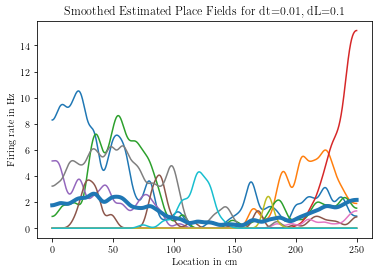

In [54]:
f = generatePlaceFields1D(M,xaxis,L)
params["f"] = f
H = h(X[:,0],f,xaxis,dL)
dN = np.random.poisson(H * dt)
spikes = dN.transpose()
X[:,0] = np.around(X[:,0],2)
xaxis = np.around(xaxis,2)
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])
estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes_train, X_train[:,0], xaxis, dt)
params["estimated_place_fields"] = estimated_place_fields
params["smoothed_place_fields"] = smoothed_place_fields
plt.plot(xaxis,np.transpose(smoothed_place_fields))
plt.plot(xaxis,np.sum(smoothed_place_fields,0)/M,linewidth=4)
plt.title("Smoothed Estimated Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

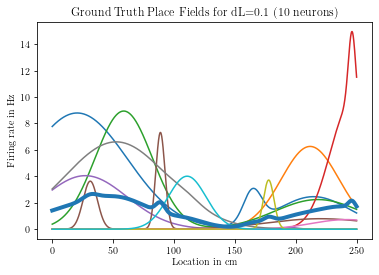

In [55]:
plt.plot(xaxis,np.transpose(f))
plt.plot(xaxis,np.sum(f,0)/M,linewidth=4)
plt.title("Ground Truth Place Fields for dL={} ({} neurons)".format(dL, M))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

### Particle Filter

In [56]:
def randomwalk_pf(spikes, params):
    T = params["T"]
    dt = params["dt"]
    P = params["P"]
    tau = params["tau"]
    Peff_min = params["Peff_min"]
    L = params["L"]
    xaxis = params["xaxis"]
    place_fields = params["smoothed_place_fields"]
    dL = params["dL"]
    q = params["q"]
    t = int(T/dt)
    
    x = np.zeros((t, 2, P))
    w = np.full((t, P), 1/P)
    
    def boundary(x_t):
        if x_t[0] <= 0:
            x_t[0] = 0
            x_t[1] = 0
        elif x_t[0] >= L:
            x_t[0] = L
            x_t[1] = 0
        return x_t
    
    for i in range(1, t):
        # particle transition
        x[i,0] = x[i-1,0] + x[i-1,1] * dt
        dW = np.random.normal(scale=np.sqrt(dt), size=P)
        x[i,1] = x[i-1,1] - (x[i-1,1] / tau) * dt + q * dW
        x[i] = np.apply_along_axis(boundary, 0, x[i])
        
        # weight update
        w[i] = w[i-1] * np.prod( poisson.pmf(spikes[i],h(x[i,0],place_fields,xaxis,dL).transpose()*dt) , 1)

        w[i] /= np.sum(w[i])
        
        while np.isnan(np.sum(w[i])):
            # all particles have 0 posterior probability, so we need to resample from the uniform
            x[i,0] = np.random.uniform(0, L, P)
            x[i,1] = 0
            w[i] = (1/P) * np.prod( poisson.pmf(spikes[i],h(x[i,0],place_fields,xaxis,dL).transpose()*dt) , 1)
            w[i] /= np.sum(w[i])
        
        if 1 / np.sum(w[i] ** 2) < Peff_min * P:
            x[i], w[i] = resample(x[i], w[i], P)
                   
    return x, w

In [71]:
x_pf, w_pf = randomwalk_pf(spikes, params)

/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [72]:
mu = np.sum(x_pf[:,0,:] * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation[:,0]).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test[:,0]).mean()

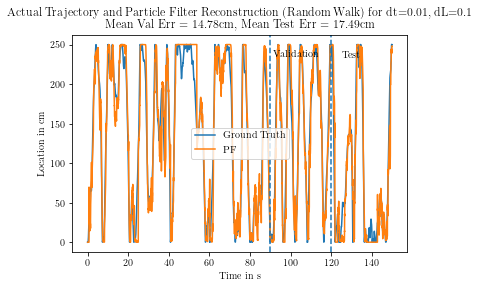

In [73]:
plt.plot(t,X[:,0])
plt.plot(t,mu)
plt.title("Actual Trajectory and Particle Filter Reconstruction (Random Walk) for dt={}, dL={}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(dt, dL, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

In [ ]:
# produces weighted histogram images
def histImage(x, bins, rang, w=0):
    image = np.zeros((x.shape[0],bins))
    
    if np.isscalar(w):
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,density=True)[0]
    else:
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,weights=w[i,:],density=True)[0]
        
    return image

In [ ]:
T_stop = 30

plotrange = [0,T_stop,0,L]

fig, (ax2) = plt.subplots(1,1,figsize=(10,6))



hist = np.transpose(histImage(x_pf[:,0,:],15,(-10,L),w=w_pf)) * 100
ax2.imshow(np.flipud(hist[:,:int(T_stop/dt)]), cmap='Oranges', interpolation='nearest', extent=[0,T_stop,0,L],aspect='auto',vmax=0.7)
ax2.plot(t[:int(T_stop/dt)],X[:int(T_stop/dt),0],color='xkcd:moss')
ax2.plot(t[:int(T_stop/dt)],np.average(x_pf[:,0,:],1,w_pf)[:int(T_stop/dt)], linewidth=1,color = 'xkcd:azure')
ax2.axis(plotrange)
ax2.legend(['hidden state','BPF'],fontsize=16)
ax2.legend([r'$x_t$',r'$\mu_t$ (BPF)'])
plt.title("IRW Ground Truth vs BPF with Weighted Heatmap of BPF Predictions")
plt.ylabel("Location in cm")
plt.xlabel("Time in s")

plt.show()

### Parameter search for IBM Model

In [ ]:
def get_error_for_params(X, spikes, q, tau):
    params["q"] = q
    params["tau"] = tau
    x_pf, w_pf = randomwalk_pf(spikes, params)
    mu = np.sum(x_pf[:,0,:] * w_pf, 1)
    mean_validation_err = abs(mu-X[:,0]).mean()
    return q, tau, mean_validation_err 

def get_error_for_params_with_range(q, tau):
    return get_error_for_params(X_validation, spikes_validation, q, tau)

In [ ]:
qs = [0.1, 0.5, 1, 2, 5, 10, 15, 20, 50, 100, 200, 1000]
taus = [0.1, 0.5, 1, 2, 5, 10, 15, 20, 50, 100, 200, 1000]
validation_errors = []

In [ ]:
params["T"] = int(len(X_validation) * dt)
pool = multiprocessing.Pool()
validation_errors = pool.starmap(get_error_for_params_with_range, product(qs, taus))
validation_errors = pd.DataFrame(validation_errors)
validation_errors.columns = ["q", "tau", "error"]

In [ ]:
validation_errors = validation_errors.sort_values(['q', 'tau'])

In [ ]:
tau_validation_errors = validation_errors.groupby('tau').mean()['error']
q_validation_errors = validation_errors.groupby('q').mean()['error']

In [ ]:
plt.xscale('log')
plt.plot(tau_validation_errors.index, tau_validation_errors.values)
plt.title(r'$\tau$ variation for IBM particle filter model')
plt.ylabel("Mean L1 Error") 
plt.axvline(params["tau"], ls='--')
plt.figtext(0.32,0.8,r"True $\tau$ = 10")
plt.xlabel(r"$\tau$")

In [ ]:
plt.xscale('log')
plt.plot(q_validation_errors.index, tau_validation_errors.values)
plt.title(r'q variation for IBM particle filter model')
plt.ylabel("Mean L1 Error") 
plt.axvline(params["q"], ls='--')
plt.figtext(0.52,0.8,r"True $q$ = 100")
plt.xlabel(r"$q$")

In [ ]:
val_errors_np = validation_errors.pivot(index='q', columns='tau', values='error')

In [ ]:
X, Y = np.meshgrid(list(val_errors_np.index), list(val_errors_np.columns))
hf = plt.figure(figsize=(10,8))
ha = hf.add_subplot(111, projection='3d')
plt.title("Hyperparameter Tuning for IBM PF")
plt.xlabel("q")
plt.ylabel(r"$\tau$")
ha.plot_surface(X.T, Y.T, np.array(val_errors_np))

plt.show()

### Behavioral Parameter Estimation

In [85]:
def fit_random_walk_model(X, dt):#, taus=None, qs=None):
#     if not taus:
#         taus = [0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20, 50, 100, 500, 1000, 5000]
#     if not qs:
#         qs = [0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20, 50, 100, 500, 1000, 5000]
#     likelihoods = {}
    base_velocity = np.diff(X[:,0]) / dt
#     base_diffs = np.diff(base_velocity)
    
#     best_tau = 0
#     best_q = 0
#     max_likelihood = float("-inf")
#     for tau, q in product(taus, qs):
#         # p(X|sigma)           
#         sd = q * np.sqrt(dt)
#         diffs = np.copy(base_diffs)
#         diffs += (dt/tau) * base_velocity[:-1]
#         diffs /= sd
#         diffs *= diffs
#         diffs = np.sum(diffs)
#         diffs *= -1/2
#         diffs += np.log(1/sd) * (X.shape[0] - 1)
#         likelihoods[tau, q] = diffs
#         if diffs > max_likelihood:
#             max_likelihood = diffs
#             best_tau = tau
#             best_q = q
            
    mu_hat = np.sum(base_velocity[1:] * base_velocity[:-1])
    mu_hat /= np.sum(base_velocity[:-1] ** 2)
    
    q_hat = np.sum((base_velocity[1:] - base_velocity[:-1] + base_velocity[:-1] * mu_hat * dt) ** 2)
    q_hat /= (X.shape[0] - 1)
    
    tau_hat = 1.0 / mu_hat
    
#     return best_q, best_tau, q_hat, tau_hat
    return q_hat, tau_hat

In [86]:
q_hat, tau_hat = fit_random_walk_model(X_train, dt)

In [88]:
def multiprocessing_params(true_q, true_tau):
    params["q"] = true_q
    params["tau"] = true_tau
    X = generate_random_walk_trajectory(params)
    q_hat, tau_hat = fit_random_walk_model(X, dt)
    return q_hat, tau_hat

In [110]:
params["T"] = int(len(X_validation) * dt)
pool = multiprocessing.Pool()
param_estimates = pool.starmap(multiprocessing_params, product(true_qs, true_taus))
param_estimates = pd.DataFrame(param_estimates)
param_estimates = pd.concat([pd.DataFrame(np.array(list(product(true_qs, true_taus)))), param_estimates], axis=1)
param_estimates.columns = ["q", "tau", "analytic_q", "analytic_tau"]

/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
